In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

### Global variables

In [2]:
j=1
eps=1.0
g=1.0
V=1.0

v = 12 #initial state
n_qubits = 4*j

In [3]:
# Parameters for time evolution

t_max = 2.0                 # Maximum evolution time
time_steps = 30            # Number of time intervals
n_trotter_steps = 10        # Number of Trotter steps

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

## Encoding Method

In [4]:
# Encode indices with the specified rule
def encode_indices(p, m, j):
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decode a single index back into multi-indices (p, m, j)
def decode_index(k, j):
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

## Test Encoding

In [5]:

for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



## Hamiltonian

In [6]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)
    
    
    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)
    
    return H

H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True, wire_map={0: 0, 1: 1, 2: 2, 3: 3})
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-1.0 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -1.0 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -1.0 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -1.0 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -0.5 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -0.5 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -0.5 * a⁺(1) a(3) a⁺(0) a(2)
+ -0.5 * a⁺(1) a(3) a⁺(1) a(3)
+ -0.5 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -0.5 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -0.5 * a⁺(3) a(1) a⁺(2) a(0)
+ -0.5 * a⁺(3) a(1) a⁺(3) a(1)

Jordan-Wigner Hamiltonian:
(-0.5+0j) * I
+ (0.5+0j) * Z(2)
+ (0.5+0j) * Z(3)
+ (-0.25+0j) * Z(2) @ Z(3)
+ (-0.25+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.25+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.25+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.25+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.25+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.25+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-

Split Hamiltonian for trotterization


## Determine hamiltonian components for trotterization

In [7]:
#construct graph from commutation relation of each term

H_list = list(zip(H_ps.keys(), H_ps.values()))

# Create an empty graph
G = nx.Graph()

# Add nodes from H_list
G.add_nodes_from(H_list)

# Compute commutators and add edges if they commute
for i in range(len(H_list)):
    for k in range(i + 1, len(H_list)):
        a = H_list[i][0]
        b = H_list[k][0]
        if len(a.commutator(b)) == 0:  # Check commutation
            G.add_edge(H_list[i], H_list[k])

G_base = G.copy()

# Print graph info
print("Nodes:", G.nodes())
print("Edges:", G.edges())


Nodes: [(I, (-0.5+0j)), (Z(2), (0.5+0j)), (Z(3), (0.5+0j)), (Z(2) @ Z(3), (-0.25+0j)), (Y(2) @ X(3) @ Y(0) @ X(1), (-0.25+0j)), (Y(2) @ X(3) @ X(0) @ Y(1), (-0.25+0j)), (Y(2) @ Y(3) @ X(0) @ X(1), (0.25+0j)), (Y(2) @ Y(3) @ Y(0) @ Y(1), (-0.25+0j)), (X(2) @ X(3) @ X(0) @ X(1), (-0.25+0j)), (X(2) @ X(3) @ Y(0) @ Y(1), (0.25+0j)), (X(2) @ Y(3) @ Y(0) @ X(1), (-0.25+0j)), (X(2) @ Y(3) @ X(0) @ Y(1), (-0.25+0j)), (Z(0) @ Z(1), (-0.25+0j))]
Edges: [((I, (-0.5+0j)), (Z(2), (0.5+0j))), ((I, (-0.5+0j)), (Z(3), (0.5+0j))), ((I, (-0.5+0j)), (Z(2) @ Z(3), (-0.25+0j))), ((I, (-0.5+0j)), (Y(2) @ X(3) @ Y(0) @ X(1), (-0.25+0j))), ((I, (-0.5+0j)), (Y(2) @ X(3) @ X(0) @ Y(1), (-0.25+0j))), ((I, (-0.5+0j)), (Y(2) @ Y(3) @ X(0) @ X(1), (0.25+0j))), ((I, (-0.5+0j)), (Y(2) @ Y(3) @ Y(0) @ Y(1), (-0.25+0j))), ((I, (-0.5+0j)), (X(2) @ X(3) @ X(0) @ X(1), (-0.25+0j))), ((I, (-0.5+0j)), (X(2) @ X(3) @ Y(0) @ Y(1), (0.25+0j))), ((I, (-0.5+0j)), (X(2) @ Y(3) @ Y(0) @ X(1), (-0.25+0j))), ((I, (-0.5+0j)), (X(2) @

In [8]:
# iter_node = nx.find_cliques(G, H_list[0])
# print(next(iter_node))

In [9]:
#finds cliques of graph

cliques = []

filter_node = True
# filter_index = 1
# node_to_filter1 = list(G.nodes())[1]
# node_to_filter2 = H_list[filter_index+1]
# print("TYPE: ", type(node_to_filter))

# subgraph = nx.subgraph(G, (node_to_filter1, node_to_filter2))

iteration = 1
while G.number_of_nodes() > 0:

    # if filter_node and iteration == 1:
    #     iter_node = nx.find_cliques(G, )#subgraph)
    #     print("Filtering node", subgraph)
    # else:
    iter_node = nx.find_cliques(G)

    # iter_node = nx.find_cliques(G)  # Find maximal cliques
    try:
        # if iteration == 1:
            # next(iter_node)
            # clique = next(iter_node)  # Get the first maximal clique    
        # else:
        clique = next(iter_node)
        # if filter_node and iteration == 1:
        #     iter_node = (clique for clique in nx.find_cliques(G) if node_to_filter in clique)
    except StopIteration:
        break  # If no more cliques, exit loop

    print(f"Iteration {iteration}: Removing clique {clique}")
    
    # Remove clique from graph
    cliques.append(clique)
    G.remove_nodes_from(clique)
    print(1)
    iteration += 1

print("Final graph (should be empty):", G.nodes())

Iteration 1: Removing clique [(Z(0) @ Z(1), (-0.25+0j)), (Z(2) @ Z(3), (-0.25+0j)), (I, (-0.5+0j)), (X(2) @ X(3) @ Y(0) @ Y(1), (0.25+0j)), (Y(2) @ Y(3) @ Y(0) @ Y(1), (-0.25+0j)), (X(2) @ Y(3) @ X(0) @ Y(1), (-0.25+0j)), (Y(2) @ X(3) @ Y(0) @ X(1), (-0.25+0j)), (Y(2) @ X(3) @ X(0) @ Y(1), (-0.25+0j)), (X(2) @ Y(3) @ Y(0) @ X(1), (-0.25+0j)), (X(2) @ X(3) @ X(0) @ X(1), (-0.25+0j)), (Y(2) @ Y(3) @ X(0) @ X(1), (0.25+0j))]
1
Iteration 2: Removing clique [(Z(3), (0.5+0j)), (Z(2), (0.5+0j))]
1
Final graph (should be empty): []


/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_8009/3487586730.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors


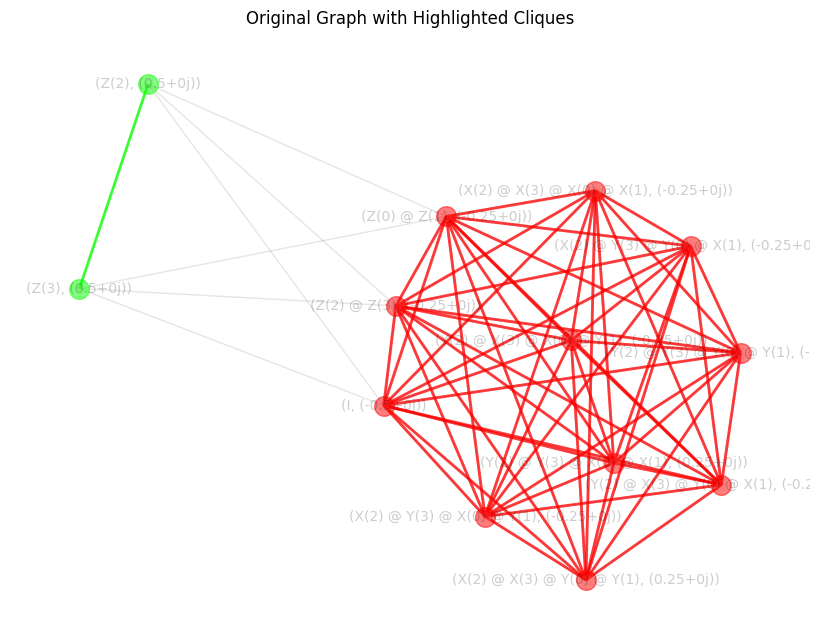

In [10]:
#plot graph with cliques

import matplotlib.pyplot as plt
import numpy as np

# Define a list of colors for different cliques
# colors = plt.cm.get_cmap("tab10", len(cliques))  # Get distinct colors
# colors = plt.cm.get_cmap("Set1", len(cliques))  # "Set1" provides bright, distinct colors

def generate_vibrant_colors(n_colors):
    """
    Generate a list of 'n_colors' distinct, vibrant colors while avoiding gray-like colors.
    """
    cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors
    colors = [cmap(i) for i in range(n_colors * 2)]  # Get extra colors to filter

    # Keep only highly saturated colors (skip grays)
    vibrant_colors = [color for color in colors if np.mean(color[:3]) < 0.75]  # Avoid desaturated tones

    return vibrant_colors[:n_colors]  # Return only the needed number of colors

# Example: Generate 15 vibrant colors with no grays
num_cliques = len(cliques)  # Arbitrary dimension
colors = generate_vibrant_colors(num_cliques)


# Plot the original graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_base)  # Position nodes

# Draw the original graph in gray (background)
# nx.draw(G_base, pos, edgelist=[], with_labels=True, node_color="red", edge_color="red", node_size=100, font_size=10)
nx.draw(G_base, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=50, font_size=10, alpha=0.2)


# Draw each clique with a different color
for i, clique in enumerate(cliques):
    nx.draw_networkx_nodes(G_base, pos, nodelist=clique, node_color=[colors[i]], node_size=200, alpha=0.5)
    nx.draw_networkx_edges(G_base, pos, edgelist=[(u, v) for u in clique for v in clique if G_base.has_edge(u, v)], edge_color=[colors[i]], width=2, alpha=0.5)

plt.title("Original Graph with Highlighted Cliques")
plt.show()

In [11]:
#separates in different hamiltonians given by cliques

H_terms = []
for i in range(len(cliques)):
    H_term = qml.pauli.PauliSentence()
    for k in range(len(cliques[i])):
        H_term[cliques[i][k][0]] = cliques[i][k][1]
    H_terms.append(H_term)

print(len(H_terms))

2


## Add Implicit Terms to Hamiltonian

In [12]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n_qubits):
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

## Automatically Calculate Commutators

In [13]:
#calculate commutators of terms in H

def test_commutativity(H):
    
    split_sentences1 = {}

    for pauli_word, value in H.items():
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences1:
            split_sentences1[pauli_word] = qml.pauli.PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences1.items(), 2):
        # Compute their commutator
        comm = qml.commutator(key1,key2, pauli=True)
        

        # Check if they commute
        if np.allclose(comm.operation().matrix(), 0):
            # print(f"{key1} and {key2} commute.")
            # print("COMMUTE")
            pass
        else:
            print("DO NOT COMMUTE")
            # print(f"{key1} and {key2} do NOT commute.")

In [14]:
for i in range(len(H_terms)):
    test_commutativity(H_terms[i])

In [15]:
#test commutation between different split of hamiltonian

import pennylane as qml

def test_commutativity_between_split(H_terms):
    """Check commutativity of all pairs in the given list of Pauli words."""
    num_terms = len(H_terms)
    commutation_results = {}

    for i in range(num_terms):
        for j in range(i + 1, num_terms):  # Check only unique pairs (i, j)
            ps1 = H_terms[i]
            ps2 = H_terms[j]
            
            # Compute the commutator using PennyLane
            comm = ps1.commutator(ps2)

            # Check if the commutator is empty (i.e., they commute)
            is_commuting = len(comm) == 0
            commutation_results[(i, j)] = is_commuting

            print(f"Commutator of term {i} and term {j}: {'Commute' if is_commuting else 'Do not commute'}")
            print(comm)

    return commutation_results

commutation_results = test_commutativity_between_split(H_terms)

Commutator of term 0 and term 1: Do not commute
-0.5j * X(2) @ Y(3) @ Y(0) @ Y(1)
+ -0.5j * Y(2) @ X(3) @ Y(0) @ Y(1)
+ -0.5j * X(2) @ X(3) @ X(0) @ Y(1)
+ 0.5j * Y(2) @ Y(3) @ X(0) @ Y(1)
+ 0.5j * Y(2) @ Y(3) @ Y(0) @ X(1)
+ -0.5j * X(2) @ X(3) @ Y(0) @ X(1)
+ 0.5j * X(2) @ Y(3) @ X(0) @ X(1)
+ 0.5j * Y(2) @ X(3) @ X(0) @ X(1)


In [16]:

# from itertools import combinations
# from pennylane.pauli import PauliSentence

# # Iterate over all pairs of PauliSentences from split_result and test commutativity
# for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
#     # Compute their commutator
#     comm = ps1.commutator(ps2)

#     # Check if they commute
#     if len(comm) == 0:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
#     else:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

## Time Evolution functions

### create initial state

In [17]:

# Initial state

dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)
initial_state[v] = 1

print(initial_state.shape)
print(n_qubits)

(16,)
4


### get matrix form of hamiltonian terms

In [18]:
#get matrix form of all the hamiltonians

order = list(range(n_qubits))

for i in range(0,n_qubits):
    order[i]=i

H = qml.matrix(H_ps, wire_order=order)

H_terms_implicit = []
for term in H_terms:
    H_terms_implicit.append(add_implicit_terms(term, n_qubits))

H_terms_mat = []
for term in H_terms_implicit:
    # H_terms_mat.append(term.operation().matrix())
    H_terms_mat.append(qml.matrix(term, wire_order=order))





### define evolution and correlation function

In [19]:

# time evolution like in the paper
def paper_evo(t, n):
    U = np.identity(H.shape[0])
    for i in range(0, n):
        for term in H_terms_mat:
            U = U @ expm(-1j * term * (t/n))

    evolved_state = U @ initial_state
    return evolved_state


# exact time evolution
def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    return evolved_state


In [20]:
#compute correlation function
def correlation_function (i, j, evo):
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zj_raw = qml.pauli.PauliWord({j:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psj = qml.pauli.PauliSentence()
    psj[Zj_raw]= 1.0

    Zi=add_implicit_terms(psi, n_qubits).operation().matrix()
    Zj=add_implicit_terms(psj, n_qubits).operation().matrix()

    evo=paper_evo(t, n_trotter_steps)
    
    sigma_ij_trotter=np.vdot(evo,Zi @ Zj @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zj @ evo)

    return sigma_ij_trotter

## Compute evolution 

### Paper Evolution

In [21]:
overlaps = []
correlations_trotter = []

# Compute the overlap with initial state
for t in times:
    result = paper_evo(t, n_trotter_steps)

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    # Compute the correlation function for trotterized evolution
    correlation_trotter = correlation_function(0, 1, result)
    correlations_trotter.append(correlation_trotter)
    




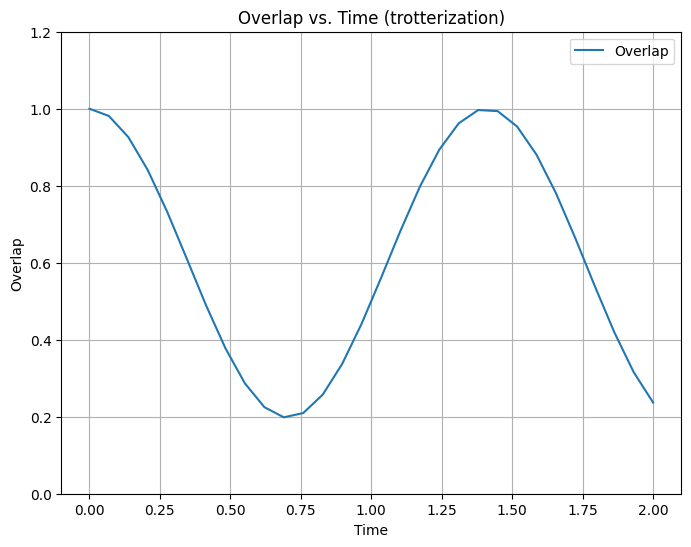

Final overlap: 0.23684595420778273


In [22]:


# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (trotterization)")
plt.grid()
plt.legend()
plt.show()

print("Final overlap:", overlaps[-1])



### Exact Evolution

In [23]:

overlaps = []
correlations_exact = []

# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)  
    #result = result.numpy()  # Convert to NumPy array if required
    
    overlap = np.vdot(initial_state, result) 
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    correlation_exact = correlation_function(0, 1, result)
    correlations_exact.append(correlation_exact)


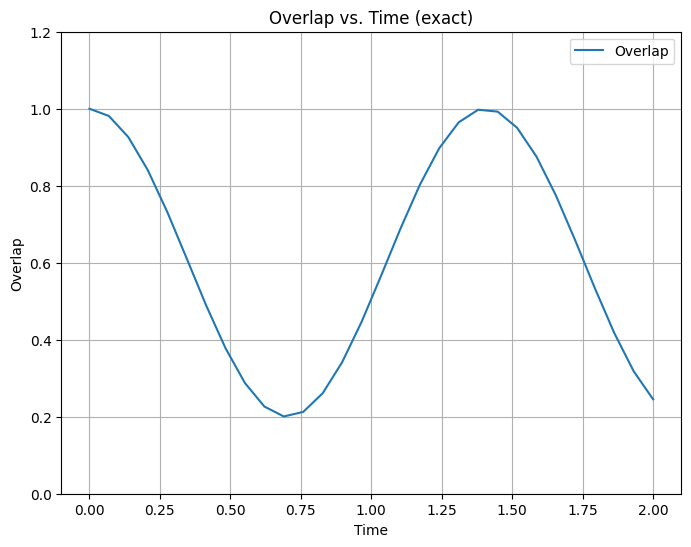

In [24]:

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



### Error

In [25]:
probabilities = []

# compute overlap between exact and paper evolution
for t in times:
    evolved_state_exact = exact_evo(t)
    evolved_state_trotter = paper_evo(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order2(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities.append(probability)

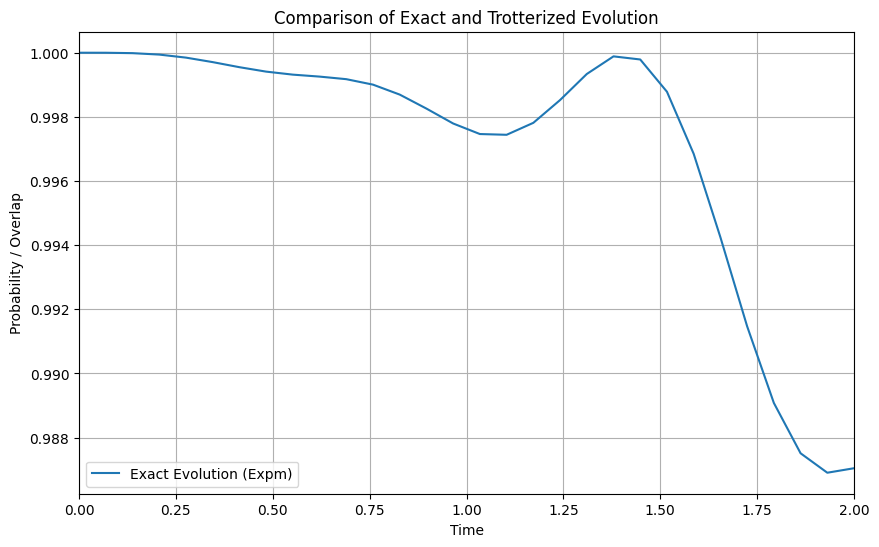

In [26]:
# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
# plt.ylim([0.999, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()

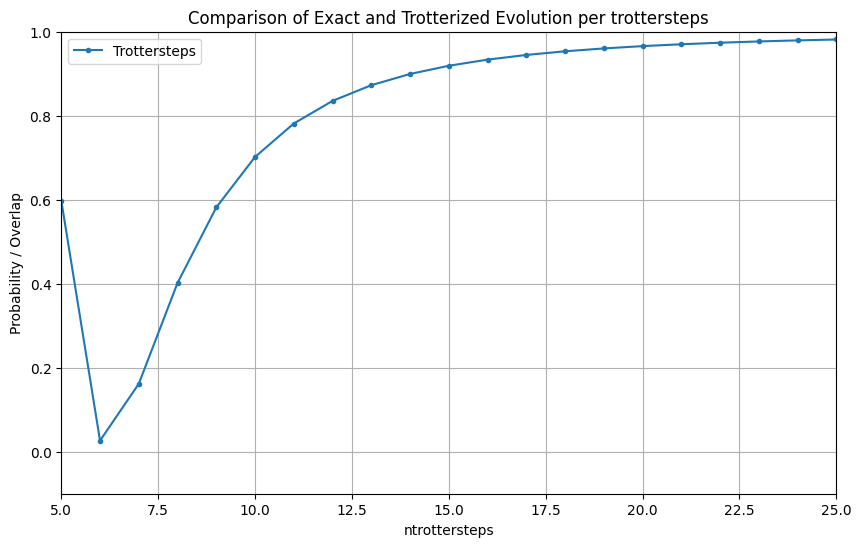

In [27]:
#comparison per number of trotter steps at given time

probabilities1 = []

min_trotter_step = 5
max_trotter_step = 25
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)

# compute overlap between exact and paper evolution
for n in trotter_steps:
    evolved_state_exact = exact_evo(5)
    evolved_state_trotter = paper_evo(5, n)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order(5, n)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities1.append(probability)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(trotter_steps, probabilities1, label="Trottersteps", marker="o", markersize=3)
plt.xlabel("ntrottersteps")
plt.ylabel("Probability / Overlap")
plt.xlim([min_trotter_step, max_trotter_step])
plt.ylim([-0.1, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution per trottersteps")
plt.grid()
plt.legend()
plt.show()


/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


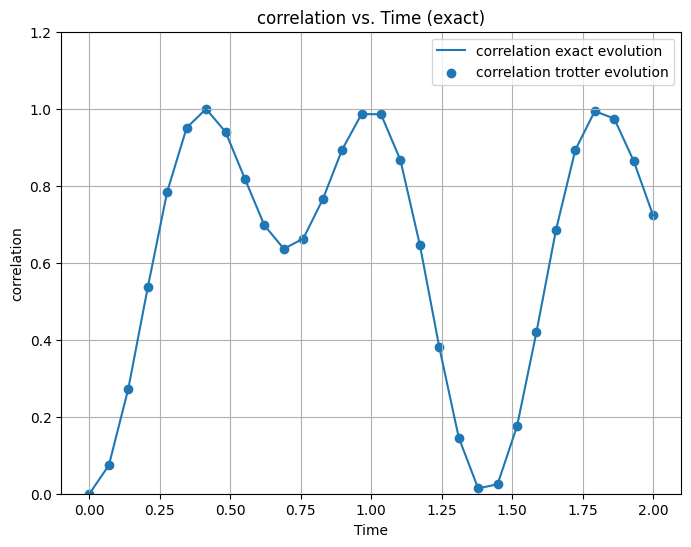

In [28]:
# Plot correlations

plt.figure(figsize=(8, 6))
plt.plot(times, correlations_exact, label="correlation exact evolution")
plt.scatter(times, correlations_trotter, label="correlation trotter evolution")
plt.xlabel("Time")
plt.ylabel("correlation")
plt.ylim([0, 1.2])
plt.title("correlation vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



## Extra

In [29]:


# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()


### Check which initial states evolve

In [30]:
#checks for every inital state which one evolves

dim = 2**n_qubits
def get_initial_state(v):
    initial_state = np.zeros(dim, dtype=complex)
    initial_state[v] = 1
    return initial_state

print(initial_state.shape)

def exact_evo_all(t, v, H):
    initial_state=get_initial_state(v)
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    overlap=np.abs(np.vdot(evolved_state, initial_state))**2
    return overlap

for v in range(0,2**n_qubits):
    print(exact_evo_all(5, v, H))

(16,)
1.0
0.9999999999999996
0.9999999999999996
0.22700129259554902
0.9999999999999996
1.0
1.0
1.0000000000000004
0.9999999999999996
1.0
1.0
1.0000000000000004
0.22700129259554871
0.9999999999999996
0.9999999999999996
0.9999999999999996
